In [16]:
# Run this cell in Colab / local with pip (preface with ! in Colab)
!pip install --upgrade pip
!pip install transformers datasets evaluate rouge-score sentencepiece tqdm streamlit


In [17]:
# Standard imports
import os
import math
import json
from tqdm.auto import tqdm
from pprint import pprint

# Data & NLP
import pandas as pd
import numpy as np

# Transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

# Dataset and evaluation
from datasets import load_dataset
import evaluate

# Plotting
import matplotlib.pyplot as plt

print("Loaded libraries.")


Loaded libraries.


In [18]:
# Check for GPU (Colab)
try:
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
except Exception:
    device = "cpu"
print("Device:", device)


Device: cpu


In [19]:
# Load a small subset first for quick iteration. Use full dataset as needed.
dataset = load_dataset("cnn_dailymail", "3.0.0")
print(dataset)
# We'll use a small sample to test quickly
small_train = dataset["train"].select(range(200))    # quick dev subset
small_val = dataset["validation"].select(range(200))
small_test = dataset["test"].select(range(200))


DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})


In [20]:
MODEL_NAME = "facebook/bart-large-cnn"

print("Loading tokenizer and model:", MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)

summarizer = pipeline(
    "summarization",
    model=model,
    tokenizer=tokenizer,
    device=0 if device=="cuda" else -1
)
print("Pipeline ready.")


Loading tokenizer and model: facebook/bart-large-cnn


Device set to use cpu


Pipeline ready.


In [21]:
# Preprocessing helper: truncate to reasonable length for model to avoid extremely long inputs.
def preprocess_text(text, max_input_chars=4000):
    # BART can handle ~1024 tokens — keep char length conservative
    if len(text) <= max_input_chars:
        return text
    return text[:max_input_chars]

# Summarize wrapper
def generate_summary(text, min_length=30, max_length=150, num_beams=4, do_sample=False):
    input_text = preprocess_text(text)
    # pipeline automatically handles tokenization, so just call it
    res = summarizer(
        input_text,
        min_length=min_length,
        max_length=max_length,
        num_beams=num_beams,
        do_sample=do_sample
    )
    return res[0]["summary_text"]


In [22]:
example = small_test[0]["article"]
print("ARTICLE (truncated):\n", example[:800], "...\n")
summary = generate_summary(example, min_length=40, max_length=120)
print("GENERATED SUMMARY:\n", summary)
print("\nREFERENCE SUMMARY:\n", small_test[0]["highlights"])


ARTICLE (truncated):
 (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. I ...

GENERATED SUMMARY:
 The Palestinian Authority becomes the 123rd member of the International Criminal Court. The move gives the court jurisdiction over alleged crimes in Pal

In [23]:
def batch_summarize(dataset_split, n=None, min_len=40, max_len=120):
    rows = []
    n = n or len(dataset_split)
    for i, ex in enumerate(tqdm(dataset_split.select(range(n)))):
        article = ex["article"]
        reference = ex["highlights"]
        pred = generate_summary(article, min_length=min_len, max_length=max_len)
        rows.append({"id": i, "article": article, "reference": reference, "prediction": pred})
    return pd.DataFrame(rows)

# Example: run on small_val (200 items)
df_val = batch_summarize(small_val, n=200)
df_val.head()


  0%|          | 0/200 [00:00<?, ?it/s]

Your max_length is set to 120, but your input_length is only 114. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=57)


,id,article,reference,prediction
0,0,"(CNN)Share, and your gift will be multiplied. ...",Zully Broussard decided to give a kidney to a ...,Zully Broussard gave one of her kidneys to a s...
1,1,"(CNN)On the 6th of April 1996, San Jose Clash ...",The 20th MLS season begins this weekend .\nLea...,The first Major League Soccer match was played...
2,2,"(CNN)French striker Bafetimbi Gomis, who has a...",Bafetimbi Gomis collapses within 10 minutes of...,"Bafetimbi Gomis says he is now ""feeling well"" ..."
3,3,(CNN)It was an act of frustration perhaps more...,Rory McIlroy throws club into water at WGC Cad...,Rory McIlroy hits his second shot into a lake ...
4,4,(CNN)A Pennsylvania community is pulling toget...,"Cayman Naib, 13, hasn't been heard from since ...","Cayman Naib, 13, has been missing since Wednes..."


In [24]:
# Use evaluate library for ROUGE
rouge = evaluate.load("rouge")

def evaluate_df(df):
    preds = df["prediction"].tolist()
    refs = df["reference"].tolist()
    # evaluate expects lists of strings
    result = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    return result

eval_results = evaluate_df(df_val)
pprint(eval_results)


{'rouge1': np.float64(0.359092758831811),
 'rouge2': np.float64(0.1625389202660783),
 'rougeL': np.float64(0.26506734982025737),
 'rougeLsum': np.float64(0.30600695356367874)}


In [25]:
# Compute length-based metrics: article_len, summary_len, compression_ratio
def compute_length_metrics(df):
    df = df.copy()
    df["article_len"] = df["article"].apply(lambda x: len(x.split()))
    df["summary_len"] = df["prediction"].apply(lambda x: len(x.split()))
    df["compression_ratio"] = df["summary_len"] / df["article_len"]
    return df

df_val = compute_length_metrics(df_val)
df_val.describe().T


,count,mean,std,min,25%,50%,75%,max
id,200.0,99.500000,57.879185,0.000000,49.750000,99.500000,149.250000,199.000000
article_len,200.0,562.050000,331.808396,81.000000,286.500000,511.500000,784.000000,1523.000000
summary_len,200.0,41.415000,7.223828,22.000000,37.000000,41.000000,45.000000,65.000000
compression_ratio,200.0,0.111752,0.084023,0.020679,0.052302,0.082421,0.142373,0.469136


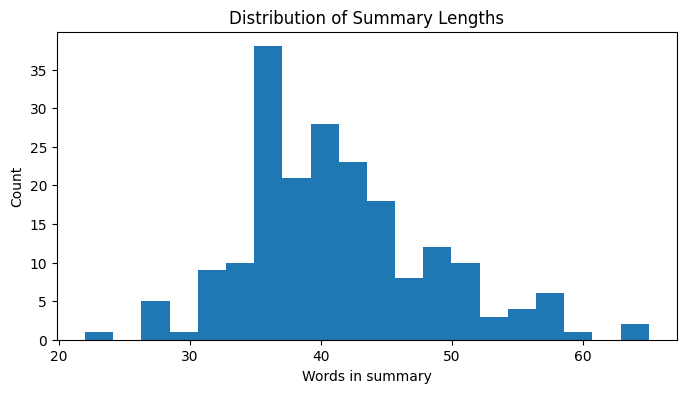

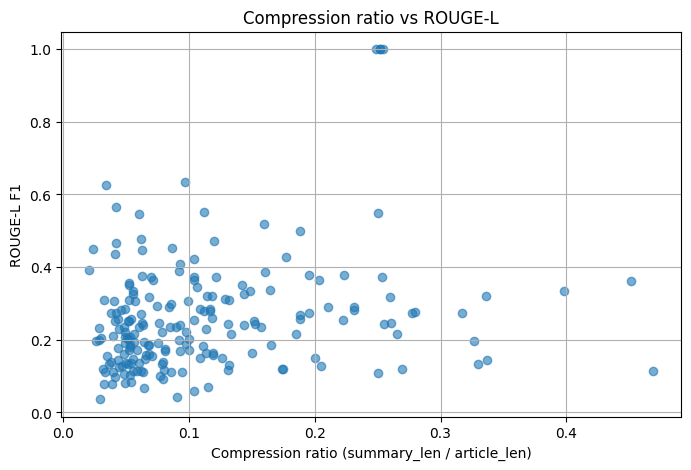

In [26]:
# Histogram: summary lengths
plt.figure(figsize=(8,4))
plt.hist(df_val["summary_len"], bins=20)
plt.title("Distribution of Summary Lengths")
plt.xlabel("Words in summary")
plt.ylabel("Count")
plt.show()

# Scatter: compression ratio vs ROUGE-L (we'll compute per-sample ROUGE-L roughly)
# For per-sample rouge we can use evaluate in a loop (slower). We'll compute ROUGE-L F1 per row.
rouge_l = evaluate.load("rouge")
per_sample_rouge_l = []
for pred, ref in zip(df_val["prediction"], df_val["reference"]):
    r = rouge_l.compute(predictions=[pred], references=[ref])
    per_sample_rouge_l.append(r["rougeL"])
df_val["rougeL_fmeasure"] = per_sample_rouge_l

plt.figure(figsize=(8,5))
plt.scatter(df_val["compression_ratio"], df_val["rougeL_fmeasure"], alpha=0.6)
plt.xlabel("Compression ratio (summary_len / article_len)")
plt.ylabel("ROUGE-L F1")
plt.title("Compression ratio vs ROUGE-L")
plt.grid(True)
plt.show()


In [27]:
# Save DataFrame to CSV
out_csv = "summaries_val_metrics.csv"
df_val.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# Save a small JSONL with id, prediction, reference
jsonl_path = "predictions_val.jsonl"
with open(jsonl_path, "w", encoding="utf-8") as f:
    for rec in df_val[["id","prediction","reference"]].to_dict(orient="records"):
        f.write(json.dumps(rec, ensure_ascii=False) + "\n")
print("Saved:", jsonl_path)


Saved: summaries_val_metrics.csv
Saved: predictions_val.jsonl
